In [28]:
import numpy as np
import os
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
from wordcloud import WordCloud,STOPWORDS
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm
import spacy as sp

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nszoni/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Import data

### Pre-covid conspiracy posts between 2016 and 2020

In [2]:
rc_precovid = pd.read_csv('../data/reddit_ct_2016_2020.csv')
rc_precovid.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"This rare image, featuring the victims of the ...",87129,cti1q4,https://i.redd.it/43kffo8bgth31.jpg,2768,1.566400e+09,NaN,2019-08-21 16:59:45
1,This was deleted twice from reddit's front page.,69819,88n2td,https://www.youtube.com/watch?v=hWLjYJ4BzvI&fe...,2124,1.522543e+09,NaN,2018-04-01 02:44:34
2,REMINDER: It has been 2866 days since Sean Han...,46610,5w55ai,http://crooksandliars.com/2016/04/today-comple...,1414,1.488044e+09,NaN,2017-02-25 18:26:06
3,"Reminder: 80 days ago a Billionaire pedophile,...",41180,dophtr,https://i.redd.it/1wrdlnwsahv31.png,1644,1.572354e+09,NaN,2019-10-29 14:03:25
4,Do you remember?,39199,g5cmiw,https://i.redd.it/l4iu3ot7c5u41.jpg,1078,1.587464e+09,NaN,2020-04-21 12:14:48


### Post-covid top conspiracy post in the last year

In [3]:
rc_postcovid = pd.read_csv('../data/reddit_ct_2021_2022.csv')
rc_postcovid.head()

,title,score,id,url,comms_num,created,body,timestamp
0,The true conspiracy that is happening in broad...,25705,okyu6g,https://i.redd.it/dozjrgtf6fb71.png,1590,1.626374e+09,NaN,2021-07-15 20:29:45
1,Yesterday The Atlantic put out an article clai...,18557,rdg5q3,https://i.redd.it/mlegrm1ulr481.jpg,1642,1.639164e+09,NaN,2021-12-10 20:15:33
2,"Welcome to 2021, where multi billion dollar oi...",17604,o9w3t8,https://i.postimg.cc/bvR2DsPd/Ll85ILeM.png,481,1.624923e+09,NaN,2021-06-29 01:29:38
3,The worst shitcoin.,16377,ngdq1r,https://i.redd.it/8y5c8drwh4071.png,883,1.621450e+09,NaN,2021-05-19 20:47:55
4,Newly released photos show Maxwell and Epstein...,16159,rc13h3,https://i.redd.it/okfldphnwd481.jpg,1961,1.638998e+09,NaN,2021-12-08 22:11:16


## Data Cleaning

In [36]:
# Label dataframes and union

rc_precovid['label'] = 'precovid'
rc_postcovid['label'] = 'postcovid'

rc = pd.concat([rc_precovid, rc_postcovid], axis=0)

#drop unused columns


rc.head()

,title,score,id,url,comms_num,created,body,timestamp,label
0,"This rare image, featuring the victims of the ...",87129,cti1q4,https://i.redd.it/43kffo8bgth31.jpg,2768,1.566400e+09,NaN,2019-08-21 16:59:45,precovid
1,This was deleted twice from reddit's front page.,69819,88n2td,https://www.youtube.com/watch?v=hWLjYJ4BzvI&fe...,2124,1.522543e+09,NaN,2018-04-01 02:44:34,precovid
2,REMINDER: It has been 2866 days since Sean Han...,46610,5w55ai,http://crooksandliars.com/2016/04/today-comple...,1414,1.488044e+09,NaN,2017-02-25 18:26:06,precovid
3,"Reminder: 80 days ago a Billionaire pedophile,...",41180,dophtr,https://i.redd.it/1wrdlnwsahv31.png,1644,1.572354e+09,NaN,2019-10-29 14:03:25,precovid
4,Do you remember?,39199,g5cmiw,https://i.redd.it/l4iu3ot7c5u41.jpg,1078,1.587464e+09,NaN,2020-04-21 12:14:48,precovid


In [37]:
rc.drop(['id', 'url', 'comms_num', 'created'], axis=1, inplace=True)

rc.head()

,title,score,body,timestamp,label
0,"This rare image, featuring the victims of the ...",87129,NaN,2019-08-21 16:59:45,precovid
1,This was deleted twice from reddit's front page.,69819,NaN,2018-04-01 02:44:34,precovid
2,REMINDER: It has been 2866 days since Sean Han...,46610,NaN,2017-02-25 18:26:06,precovid
3,"Reminder: 80 days ago a Billionaire pedophile,...",41180,NaN,2019-10-29 14:03:25,precovid
4,Do you remember?,39199,NaN,2020-04-21 12:14:48,precovid


## Text Processing

In [44]:
# Separate to title and body
title_data = rc[['title','timestamp','label']].copy()
body_data = rc[['body','timestamp','label']].copy()
body_data = body_data.dropna()
title_data = title_data.dropna()

#Cast timestamp to date
title_data.timestamp = pd.to_datetime(title_data.timestamp).dt.date
body_data.timestamp = pd.to_datetime(body_data.timestamp).dt.date

In [39]:
lemmatizer = WordNetLemmatizer()

def text_preprocess_lemmatize(text: str) -> str:
    
    '''
    - remove handlers (eg. @username)
    - remove urls
    - remove any non-word elements (inc. punctuation)
    - remove single letters
    - remove digits
    - replace multiple spaces with a single space
    - tokenize text
    - filter out stopwords
    - lemmatize tokens
    - filter out tokens with less than 3 characters
    '''
    garbage = re.compile('@[^\s]+|http\S+|\W|\s+[a-zA-Z]\s+|\d+|\s+')
    
    text = text.lower()
    text= re.sub(garbage,' ', text)
    
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in set(stopwords.words('english'))]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [word for word in tokens if len(word)>=3]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

In [45]:
body_data['cleaned'] = body_data['body'].apply(text_preprocess_lemmatize)

In [46]:
body_data.head()

,body,timestamp,label,cleaned
49,"Yesterday, a [link to South Park's latest epis...",2019-10-08,precovid,yesterday link south park latest episode band ...
75,This needs to be said.\n\nEdit: to all those w...,2017-03-29,precovid,need said edit think still trump supporter kno...
95,"Well, I didn’t get much sleep and [posting thi...",2019-08-16,precovid,well get much sleep posting recommendation doc...
96,A ring was just brought down in Florida and ba...,2019-02-22,precovid,ring brought florida based good intel certain ...
104,"Reposted due to ""violation of rule 6""",2017-07-12,precovid,reposted due violation rule


In [47]:
#drop rows where cleaned is null
body_data['cleaned'].replace('', np.nan, inplace=True)
body_data = body_data[body_data['cleaned'].notna()]

## Feature Engineering

In [48]:
# Apply SIA from Vader package

sid = sia()
body_data['sentiments'] = body_data['body'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

In [43]:
body_data.head()

,body,timestamp,cleaned,sentiments
49,"Yesterday, a [link to South Park's latest epis...",2019-10-08,yesterday link south park latest episode band ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
75,This needs to be said.\n\nEdit: to all those w...,2017-03-29,need said edit think still trump supporter kno...,"{'neg': 0.19, 'neu': 0.726, 'pos': 0.084, 'com..."
95,"Well, I didn’t get much sleep and [posting thi...",2019-08-16,well get much sleep posting recommendation doc...,"{'neg': 0.063, 'neu': 0.841, 'pos': 0.096, 'co..."
96,A ring was just brought down in Florida and ba...,2019-02-22,ring brought florida based good intel certain ...,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp..."
104,"Reposted due to ""violation of rule 6""",2017-07-12,reposted due violation rule,"{'neg': 0.39, 'neu': 0.61, 'pos': 0.0, 'compou..."


In [49]:
# Parse out dict elements

body_data['positive'] = body_data['sentiments'].apply(lambda x: x['pos']) 
body_data['neutral'] = body_data['sentiments'].apply(lambda x: x['neu'])
body_data['negative'] = body_data['sentiments'].apply(lambda x: x['neg'])
body_data['compound'] = body_data['sentiments'].apply(lambda x: x['compound'])

In [50]:
body_data.head()

,body,timestamp,label,cleaned,sentiments,positive,neutral,negative,compound
49,"Yesterday, a [link to South Park's latest epis...",2019-10-08,precovid,yesterday link south park latest episode band ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
75,This needs to be said.\n\nEdit: to all those w...,2017-03-29,precovid,need said edit think still trump supporter kno...,"{'neg': 0.19, 'neu': 0.726, 'pos': 0.084, 'com...",0.084,0.726,0.190,-0.9875
95,"Well, I didn’t get much sleep and [posting thi...",2019-08-16,precovid,well get much sleep posting recommendation doc...,"{'neg': 0.063, 'neu': 0.841, 'pos': 0.096, 'co...",0.096,0.841,0.063,0.9994
96,A ring was just brought down in Florida and ba...,2019-02-22,precovid,ring brought florida based good intel certain ...,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",0.217,0.783,0.000,0.6124
104,"Reposted due to ""violation of rule 6""",2017-07-12,precovid,reposted due violation rule,"{'neg': 0.39, 'neu': 0.61, 'pos': 0.0, 'compou...",0.000,0.610,0.390,-0.4939


We will consider posts with a compound value greater than 0.2 as positive and less than -0.2 as negative. There's some testing and experimentation that goes with choosing these ranges, and there is a trade-off to be made here. If you choose a higher value, you might get more compact results (less false positives and false negatives), but the size of the results will decrease significantly.

Let's create a positive label of 1 if the compound is greater than 0.2, and a label of -1 if compound is less than -0.2. Everything else will be 0.

In [51]:
THRESHOLD = 0.2

conditions = [
    (body_data['compound'] <= -THRESHOLD),
    (body_data['compound'] > -THRESHOLD) & (body_data['compound'] < THRESHOLD),
    (body_data['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
body_data['sentiment'] = np.select(conditions, values)

In [52]:
body_data.head()

,body,timestamp,label,cleaned,sentiments,positive,neutral,negative,compound,sentiment
49,"Yesterday, a [link to South Park's latest epis...",2019-10-08,precovid,yesterday link south park latest episode band ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu
75,This needs to be said.\n\nEdit: to all those w...,2017-03-29,precovid,need said edit think still trump supporter kno...,"{'neg': 0.19, 'neu': 0.726, 'pos': 0.084, 'com...",0.084,0.726,0.190,-0.9875,neg
95,"Well, I didn’t get much sleep and [posting thi...",2019-08-16,precovid,well get much sleep posting recommendation doc...,"{'neg': 0.063, 'neu': 0.841, 'pos': 0.096, 'co...",0.096,0.841,0.063,0.9994,pos
96,A ring was just brought down in Florida and ba...,2019-02-22,precovid,ring brought florida based good intel certain ...,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",0.217,0.783,0.000,0.6124,pos
104,"Reposted due to ""violation of rule 6""",2017-07-12,precovid,reposted due violation rule,"{'neg': 0.39, 'neu': 0.61, 'pos': 0.0, 'compou...",0.000,0.610,0.390,-0.4939,neg


### Feature Extraction

In [53]:
body_data['num_words'] = body_data['body'].apply(lambda x: len(x.split(' ')))
body_data['num_stopwords'] = body_data['body'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
body_data['avg_word_length'] = body_data['body'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))

In [54]:
body_data.head()

,body,timestamp,label,cleaned,sentiments,positive,neutral,negative,compound,sentiment,num_words,num_stopwords,avg_word_length
49,"Yesterday, a [link to South Park's latest epis...",2019-10-08,precovid,yesterday link south park latest episode band ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu,91,30,23.262295
75,This needs to be said.\n\nEdit: to all those w...,2017-03-29,precovid,need said edit think still trump supporter kno...,"{'neg': 0.19, 'neu': 0.726, 'pos': 0.084, 'com...",0.084,0.726,0.190,-0.9875,neg,208,101,7.663551
95,"Well, I didn’t get much sleep and [posting thi...",2019-08-16,precovid,well get much sleep posting recommendation doc...,"{'neg': 0.063, 'neu': 0.841, 'pos': 0.096, 'co...",0.096,0.841,0.063,0.9994,pos,4634,1802,6.685734
96,A ring was just brought down in Florida and ba...,2019-02-22,precovid,ring brought florida based good intel certain ...,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",0.217,0.783,0.000,0.6124,pos,22,9,4.923077
104,"Reposted due to ""violation of rule 6""",2017-07-12,precovid,reposted due violation rule,"{'neg': 0.39, 'neu': 0.61, 'pos': 0.0, 'compou...",0.000,0.610,0.390,-0.4939,neg,7,2,5.400000


## EDA

### Do people write lenghty posts after COVID?

<AxesSubplot:xlabel='label', ylabel='num_words'>

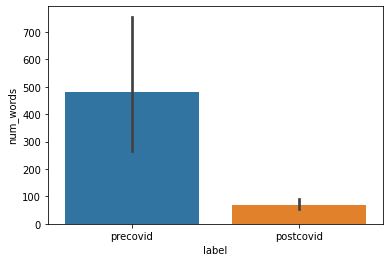

In [58]:
sns.barplot(x='label', y='num_words', data=body_data)

### Distribution of sentiment categories

<AxesSubplot:xlabel='sentiment', ylabel='count'>

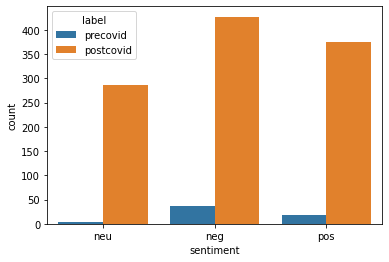

In [60]:
sns.countplot(x='sentiment', hue='label', data=body_data)

## Sentiment Analysis

## Topic Modelling